# 1. Install required packages

In [79]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 3. Data Preparation

## 3.1 Vale

In [ ]:
#Leitura dos dados
vale = pd.read_csv('/Users/jeffsantos/Desktop/9DTSR/git/9DTSR/Reinforcement Learning/Trabalho Integrado/vale.csv')

#Análise de nulos
print('Null Values =',vale.isnull().values.any())
vale=vale.bfill()

#Seleção de colunas
df_vale = vale[['Date', 'Close']][vale['Date'] >= '2024-04-01'].copy()
df_vale.head(5)

,Date,Close,High,Low,Open,Volume
0,2020-01-02,33.844028,33.912549,33.482725,33.626000,17509700
1,2020-01-03,33.594856,33.949929,33.376830,33.439123,17284800
2,2020-01-06,33.395515,33.513872,33.108966,33.513872,32787800
3,2020-01-07,33.638454,33.756811,33.264695,33.326987,16326400
4,2020-01-08,33.644684,33.868941,33.401740,33.763043,15298500


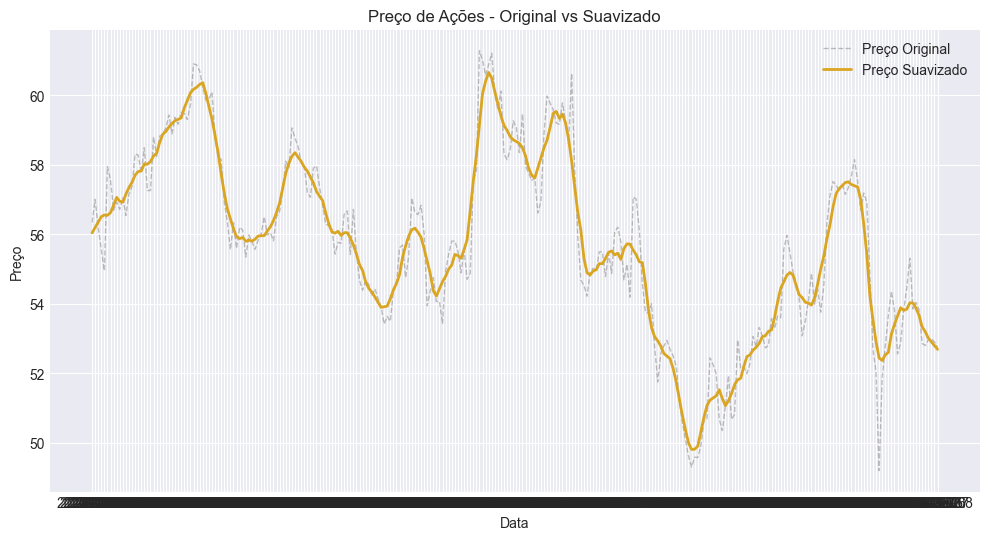

In [ ]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

#Suavização dos dados para treinamento
df_vale['preco_suavizado'] = savgol_filter(df_vale['Close'], window_length=7, polyorder=1)

#Visualização dos dados
plt.figure(figsize=(12, 6))
plt.plot(df_vale['Date'], df_vale['Close'], label='Preço Original', alpha=0.5, color='gray', linewidth=1, linestyle='--')
plt.plot(df_vale['Date'], df_vale['preco_suavizado'], label='Preço Suavizado', color='#DAA520', linewidth=2, linestyle='-')
plt.legend()
plt.title('Preço de Ações - Original vs Suavizado')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.show()

## 2.2 Petrobras

In [ ]:
#Leitura dos dados
petro = pd.read_csv('/Users/jeffsantos/Desktop/9DTSR/git/9DTSR/Reinforcement Learning/Trabalho Integrado/petro.csv')

#Análise de nulos
print('Null Values =',petro.isnull().values.any())
petro=petro.bfill()

#Seleção de colunas
df_petro = petro[['Date', 'Close']][petro['Date'] >= '2024-04-01'].copy()
df_petro.head(5)


,Date,Close,High,Low,Open,Volume
0,2020-01-02,12.231461,12.231461,12.076077,12.155761,37774500
1,2020-01-03,12.131855,12.446606,12.131855,12.303174,71595600
2,2020-01-06,12.275287,12.327082,11.932647,12.123888,81844000
3,2020-01-07,12.227476,12.303175,12.139823,12.279270,32822000
4,2020-01-08,12.151779,12.259352,12.048190,12.227479,48215600


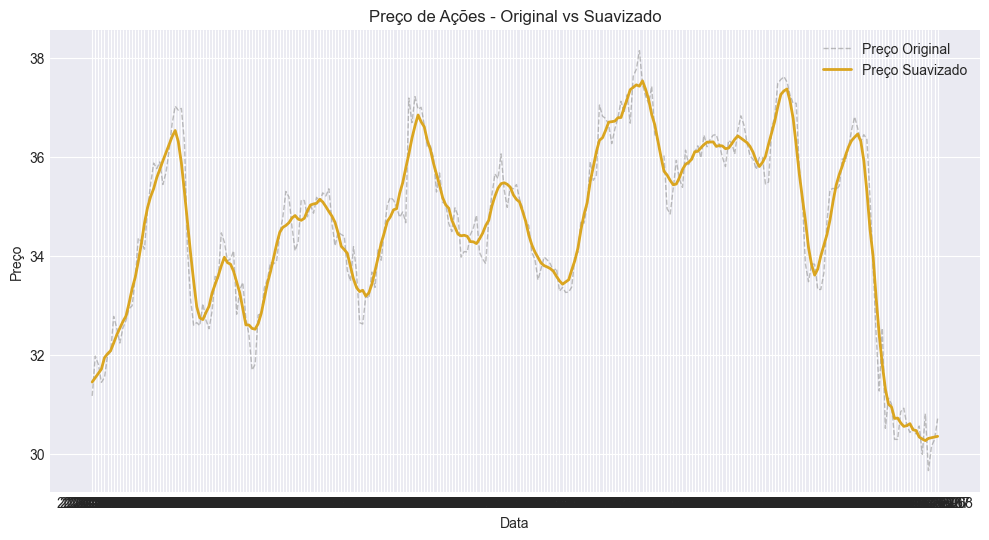

In [ ]:
#Suavização dos dados para treinamento
df_petro['preco_suavizado'] = savgol_filter(df_petro['Close'], window_length=7, polyorder=1)

#Visualização dos dados
plt.figure(figsize=(12, 6))
plt.plot(df_petro['Date'], df_petro['Close'], label='Preço Original', alpha=0.5, color='gray', linewidth=1, linestyle='--')
plt.plot(df_petro['Date'], df_petro['preco_suavizado'], label='Preço Suavizado', color='#DAA520', linewidth=2, linestyle='-')
plt.legend()
plt.title('Preço de Ações - Original vs Suavizado')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.show()

## 2.3 BR Foods

In [99]:
#Leitura dos dados
brfoods = pd.read_csv('/Users/jeffsantos/Desktop/9DTSR/git/9DTSR/Reinforcement Learning/Trabalho Integrado/brfood.csv')

#Análise de nulos
print('Null Values =',brfoods.isnull().values.any())
brfoods=brfoods.bfill()

#Seleção de colunas
df_brfoods = brfoods[['Date', 'Close']][brfoods['Date'] >= '2024-04-01'].copy()
df_brfoods.head(5)


Null Values = False


,Date,Close
1054,2024-04-01,15.566506
1055,2024-04-02,15.537319
1056,2024-04-03,15.585965
1057,2024-04-04,15.537319
1058,2024-04-05,15.731901


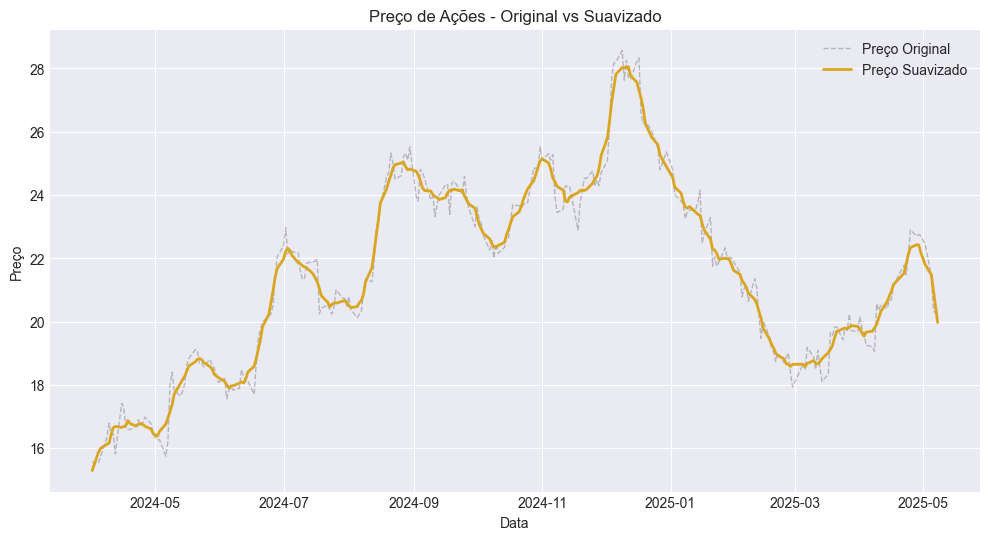

In [101]:
#Suavização dos dados para treinamento
df_brfoods['preco_suavizado'] = savgol_filter(df_brfoods['Close'], window_length=7, polyorder=1)

#Visualização dos dados
plt.figure(figsize=(12, 6))
plt.plot(df_brfoods['Date'], df_brfoods['Close'], label='Preço Original', alpha=0.5, color='gray', linewidth=1, linestyle='--')
plt.plot(df_brfoods['Date'], df_brfoods['preco_suavizado'], label='Preço Suavizado', color='#DAA520', linewidth=2, linestyle='-')
plt.legend()
plt.title('Preço de Ações - Original vs Suavizado')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.show()

# 4. Creating a Model

## 4.1 Criando o ambiente

In [83]:
import numpy as np

class TradingEnvironment:
    def __init__(self, data, initial_balance=10000):
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.reset()
    
    def reset(self):
        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = 5  # Começa em 5 para permitir ma_5
        self.done = False
        self.total_profit = 0
        self.invalid_action = False
        self.portfolio_value = self.initial_balance
        self.initial_price = self.data.iloc[0]
        return self._get_state()   
    
    def _get_state(self):
        price = self.data.iloc[self.current_step]
        
        # Histórico de preços (variação percentual dos últimos 3 dias)
        past_prices = self.data.iloc[self.current_step-3:self.current_step].values
        price_history = (past_prices / price) - 1  # Normalizado em torno de 0

        # Médias móveis e volatilidade (normalizadas pelo preço atual)
        ma_3 = np.mean(past_prices) / price
        ma_5 = np.mean(self.data.iloc[self.current_step-5:self.current_step]) / price
        volatility = np.std(past_prices) / price

        # Normalizações
        price_norm = price / self.initial_price
        balance_norm = self.balance / self.initial_balance
        shares_norm = self.shares_held / 1000  # ajuste se necessário

        # Vetor final do estado
        state = np.array(
            [price_norm, balance_norm, shares_norm, ma_3, ma_5, volatility] + list(price_history),
            dtype=np.float32
        )
        return state
    
    def step(self, action):
        price = self.data.iloc[self.current_step]
        reward = 0

        prev_portfolio_value = self.balance + self.shares_held * price
        
        if action == 0:  # Comprar
            max_shares = int(self.balance // price)
            if max_shares > 0:
                total_cost = max_shares * price
                self.shares_held += max_shares
                self.balance -= total_cost
            else:
                self.invalid_action = True
                reward += 1
        
        elif action == 1:  # Vender
            if self.shares_held > 0:
                total_revenue = self.shares_held * price
                self.balance += total_revenue
                self.shares_held = 0
            else:
                self.invalid_action = True
                reward += 1
        
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True
        
        current_price = self.data.iloc[self.current_step]
        self.portfolio_value = self.balance + (self.shares_held * current_price)
        
        if action == 2:  # Ficar parado
            reward -= 0

        # Recompensa combinada
        delta_current = (self.portfolio_value - prev_portfolio_value) / self.initial_balance
        delta_total = (self.portfolio_value - self.initial_balance) / self.initial_balance
        reward += 0.10 * delta_current + 0.90 * delta_total

        if self.done:
            final_reward = (self.portfolio_value - self.initial_balance) / self.initial_balance
            reward += final_reward * len(self.data) * 0.8

        state = self._get_state()
        return state, reward, self.done, {}


## 4.2 Criando a rede neural

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import random

In [85]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, action_size)
    
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))  
        x = torch.relu(self.fc4(x))
        return self.fc5(x)

## 4.3 Criando a política de ação

In [86]:
import random
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

class DQNAgent:
    def __init__(self, state_size, action_size, batch_size=128, memory_size=300000, target_update_freq=100):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = 0.99

        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        self.memory = deque(maxlen=memory_size)
        self.model = QNetwork(state_size, action_size)
        self.target_model = QNetwork(state_size, action_size)
        self.update_target_network()

        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0005)
        self.criterion = nn.SmoothL1Loss() #MSELoss

        self.train_step = 0
        self.target_update_freq = target_update_freq

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if done and reward > 200:
            # Se for o último step, repete o armazenamento para aumentar a chance de amostragem
            for _ in range(8):  
                self.memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.bool).unsqueeze(1)

        # Q-atual
        q_values = self.model(states).gather(1, actions)

        # Q-futuro do target
        next_q_values = self.target_model(next_states).max(1)[0].unsqueeze(1)
        target = rewards + self.gamma * next_q_values * (~dones).float()


        loss = self.criterion(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Atualiza a target network a cada N passos
        self.train_step += 1 #ajustar
        if self.train_step % self.target_update_freq == 0:
            self.update_target_network()

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# 5. Simular e treinar o Agente
## 5.1 Vale

Episode 10/400 completed with portfolio of 9284. Com sugestão de ação 1 e recompensa acumulada de 72.8.
Episode 20/400 completed with portfolio of 9713. Com sugestão de ação 0 e recompensa acumulada de 86.0.
Episode 30/400 completed with portfolio of 9743. Com sugestão de ação 1 e recompensa acumulada de 113.2.
Episode 40/400 completed with portfolio of 10602. Com sugestão de ação 2 e recompensa acumulada de 140.8.
Episode 50/400 completed with portfolio of 9652. Com sugestão de ação 0 e recompensa acumulada de 112.2.
Episode 60/400 completed with portfolio of 9561. Com sugestão de ação 2 e recompensa acumulada de 135.4.
Episode 70/400 completed with portfolio of 9405. Com sugestão de ação 2 e recompensa acumulada de 134.4.
Episode 80/400 completed with portfolio of 10441. Com sugestão de ação 2 e recompensa acumulada de 163.6.
Episode 90/400 completed with portfolio of 8740. Com sugestão de ação 1 e recompensa acumulada de 97.1.
Episode 100/400 completed with portfolio of 9954. Com su

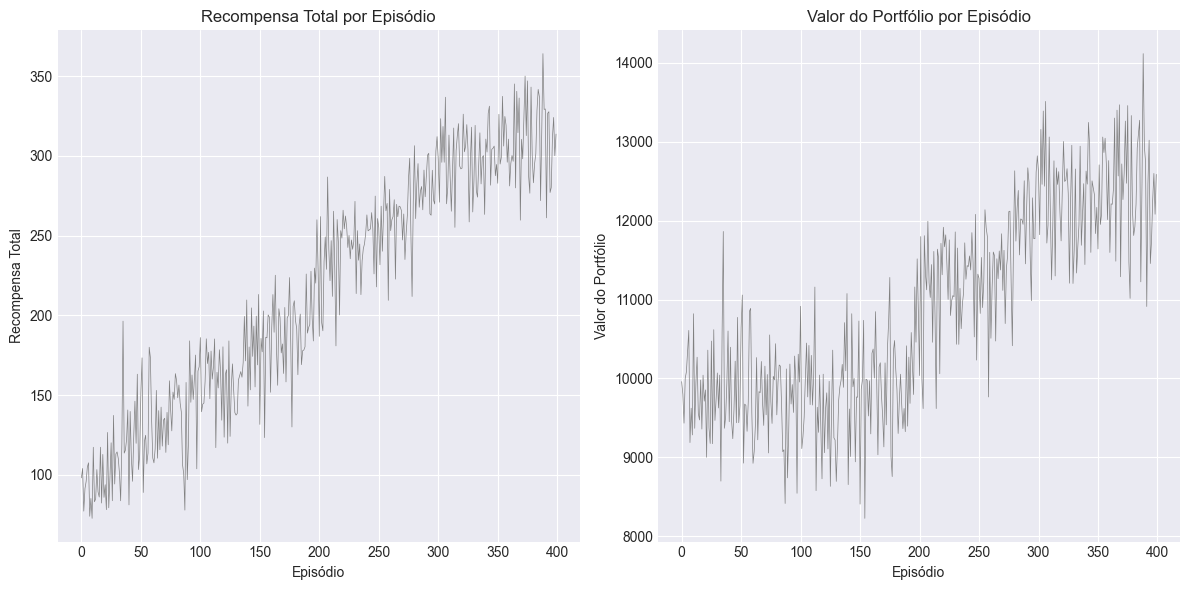

In [87]:
import matplotlib.pyplot as plt

# Definir o tamanho do estado e da ação
state_size = 9  # Preço, saldo, ações
action_size = 3  # Comprar, vender, manter

# Criar o ambiente de negociação
env = TradingEnvironment(df_vale['preco_suavizado'], initial_balance=10000)

# Criar o agente
state = env.reset()
agent = DQNAgent(state_size, action_size)

# Listas para armazenar métricas
total_rewards = []  # Para armazenar recompensa total por episódio
portfolio_values = []  # Para armazenar o valor do portfólio no final de cada episódio

# Treinamento
episodes = 400
max_portfolio_value = 0
last_episodio = []
mid_episodio = []
max_episodio = []

for episode in range(episodes):
    state = env.reset()
    done = False
    episode_reward = 0  # Recompensa acumulada por episódio
    daily_values = []
    step_count = 0
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.store_experience(state, action, reward, next_state, done)
        step_count += 1
        if step_count % 1 == 0:
            agent.train()
        state = next_state
        episode_reward += reward  # Acumulando a recompensa no episódio
        
        daily_values.append(env.portfolio_value)
    
    # Atualizar a exploração
    agent.update_epsilon()
    
    # Armazenar métricas
    total_rewards.append(episode_reward)
    portfolio_values.append(env.portfolio_value)
    
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}/{episodes} completed with portfolio of {round(env.portfolio_value)}. Com sugestão de ação {action} e recompensa acumulada de {round(episode_reward,1)}.")
    
    # Armazenar o valor do portfólio diário para análise gráfica
    if episode == episodes - 1:
        last_daily_values = daily_values
        last_episodio = episode + 1
    
    if episode == (episodes)/2:
        mid_daily_values = daily_values
        mid_episodio = episode
    
    if daily_values[-1] >= max_portfolio_value:
        max_portfolio_value = daily_values[-1]
        max_episodio = episode + 1
        max_daily_values = daily_values

# Plotar as métricas
plt.figure(figsize=(12, 6))

# Gráfico de recompensa total por episódio
plt.subplot(1, 2, 1)
plt.plot(total_rewards, color='gray', linewidth=0.5)
plt.title("Recompensa Total por Episódio")
plt.xlabel("Episódio")
plt.ylabel("Recompensa Total")

# Gráfico do valor do portfólio ao longo dos episódios
plt.subplot(1, 2, 2)
plt.plot(portfolio_values, color='gray', linewidth=0.5)
plt.title("Valor do Portfólio por Episódio")
plt.xlabel("Episódio")
plt.ylabel("Valor do Portfólio")

plt.tight_layout()
plt.show()


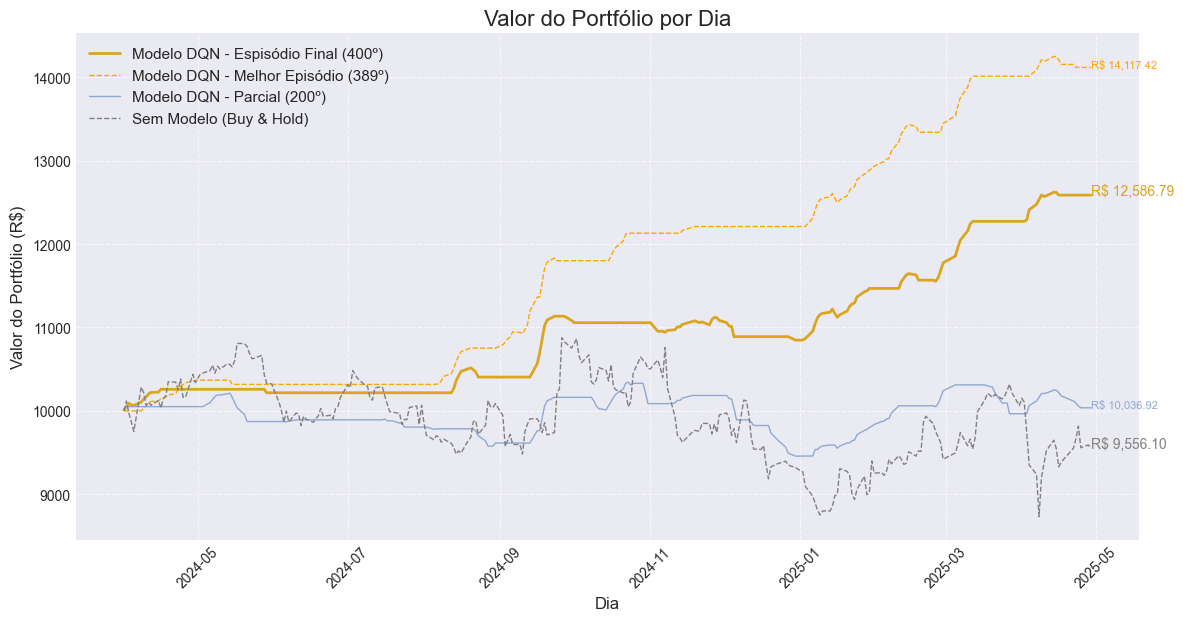

In [88]:
import pandas as pd 

initial_balance = 10000
num_acoes = initial_balance / df_vale['Close'].iloc[0]
portfolio_values_real = df_vale['Close'] * num_acoes

# Garantir que a coluna 'Date' está no formato datetime
df_vale['Date'] = pd.to_datetime(df_vale['Date'])

# Garantir que ambas as listas tenham o mesmo tamanho
min_length = min(len(last_daily_values), len(portfolio_values_real), len(df_vale['Date']))
last_daily_values = last_daily_values[:min_length]
portfolio_values_real = portfolio_values_real[:min_length]
dates = df_vale['Date'][:min_length]

# Estilo do gráfico
plt.style.use('seaborn-v0_8-darkgrid')  

# Plotando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(dates, last_daily_values, label=f'Modelo DQN - Espisódio Final ({last_episodio}º)', color='#DAA520', linewidth=2, linestyle='-')
plt.plot(dates, max_daily_values, label= f'Modelo DQN - Melhor Episódio ({max_episodio}º)', color='orange', linewidth=1, linestyle='--')
plt.plot(dates, mid_daily_values, label=f'Modelo DQN - Parcial ({mid_episodio}º)', color='#91A8D0', linewidth=1, linestyle='-')
plt.plot(dates, portfolio_values_real, label='Sem Modelo (Buy & Hold)', color='gray', linewidth=1, linestyle='--')

# Adicionando título e labels
plt.title("Valor do Portfólio por Dia", fontsize=16)
plt.xlabel("Dia", fontsize=12)
plt.ylabel("Valor do Portfólio (R$)", fontsize=12)

# Adicionando legendas e textos nos pontos finais
plt.legend(loc='best', fontsize=11)
plt.text(dates.iloc[-1], last_daily_values[-1], f'R$ {last_daily_values[-1]:,.2f}', color='#DAA520', fontsize=10)
plt.text(dates.iloc[-1], max_daily_values[-1],  f'R$ {max_daily_values[-1]:,.2f}',  color='orange',  fontsize=8)
plt.text(dates.iloc[-1], mid_daily_values[-1],  f'R$ {mid_daily_values[-1]:,.2f}',  color='#91A8D0', fontsize=8)
plt.text(dates.iloc[-1], portfolio_values_real.iloc[-1], f'R$ {portfolio_values_real.iloc[-1]:,.2f}', color='gray', fontsize=10)

# Adicionando a grade
plt.grid(True, linestyle='--', alpha=0.7)

# Ajustando layout e exibindo o gráfico
plt.tight_layout()
plt.xticks(rotation=45)  # Opcional, para girar as datas e evitar sobreposição
plt.show()
#9862


## 5.2 Petrobras

Episode 10/400 completed with portfolio of 9820. Com sugestão de ação 0 e recompensa acumulada de 112.5.
Episode 20/400 completed with portfolio of 8905. Com sugestão de ação 0 e recompensa acumulada de 91.9.
Episode 30/400 completed with portfolio of 9356. Com sugestão de ação 2 e recompensa acumulada de 86.3.
Episode 40/400 completed with portfolio of 10371. Com sugestão de ação 2 e recompensa acumulada de 141.9.
Episode 50/400 completed with portfolio of 10101. Com sugestão de ação 2 e recompensa acumulada de 140.2.
Episode 60/400 completed with portfolio of 10476. Com sugestão de ação 2 e recompensa acumulada de 145.2.
Episode 70/400 completed with portfolio of 10936. Com sugestão de ação 0 e recompensa acumulada de 195.5.
Episode 80/400 completed with portfolio of 9285. Com sugestão de ação 0 e recompensa acumulada de 122.5.
Episode 90/400 completed with portfolio of 10697. Com sugestão de ação 1 e recompensa acumulada de 189.9.
Episode 100/400 completed with portfolio of 9763. Co

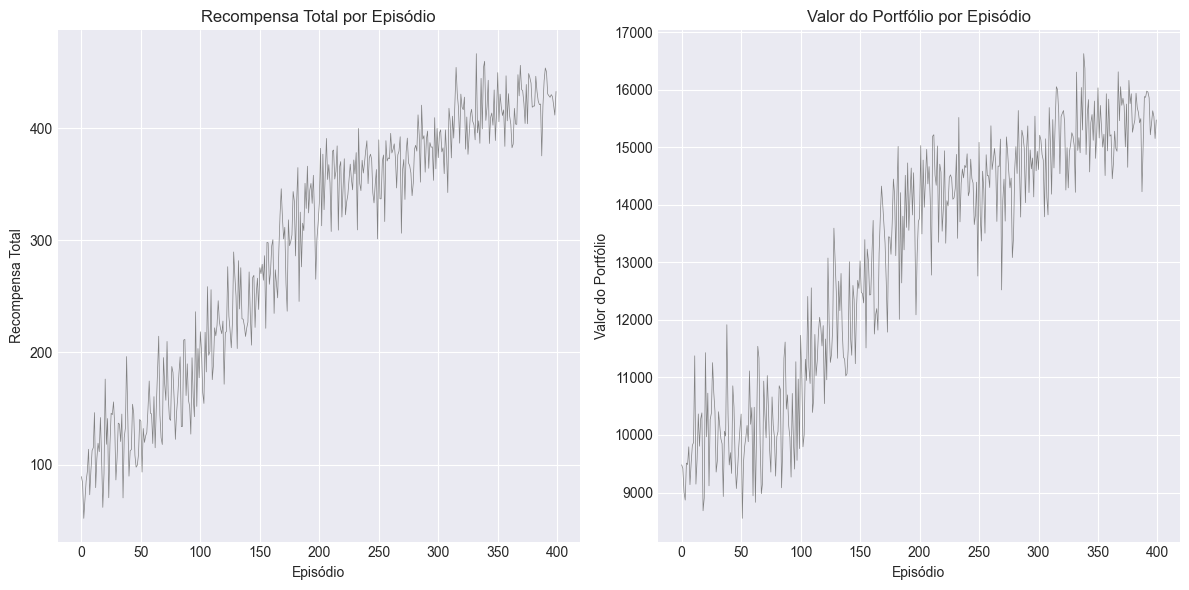

In [97]:
import matplotlib.pyplot as plt

# Definir o tamanho do estado e da ação
state_size = 9  # Preço, saldo, ações
action_size = 3  # Comprar, vender, manter

# Criar o ambiente de negociação
env = TradingEnvironment(df_petro['preco_suavizado'], initial_balance=10000)

# Criar o agente
state = env.reset()
agent = DQNAgent(state_size, action_size)

# Listas para armazenar métricas
total_rewards = []  # Para armazenar recompensa total por episódio
portfolio_values = []  # Para armazenar o valor do portfólio no final de cada episódio

# Treinamento
episodes = 400
max_portfolio_value = 0
last_episodio = []
mid_episodio = []
max_episodio = []

for episode in range(episodes):
    state = env.reset()
    done = False
    episode_reward = 0  # Recompensa acumulada por episódio
    daily_values = []
    step_count = 0
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.store_experience(state, action, reward, next_state, done)
        step_count += 1
        if step_count % 1 == 0:
            agent.train()
        state = next_state
        episode_reward += reward  # Acumulando a recompensa no episódio
        
        daily_values.append(env.portfolio_value)
    
    # Atualizar a exploração
    agent.update_epsilon()
    
    # Armazenar métricas
    total_rewards.append(episode_reward)
    portfolio_values.append(env.portfolio_value)
    
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}/{episodes} completed with portfolio of {round(env.portfolio_value)}. Com sugestão de ação {action} e recompensa acumulada de {round(episode_reward,1)}.")
    
    # Armazenar o valor do portfólio diário para análise gráfica
    if episode == episodes - 1:
        last_daily_values = daily_values
        last_episodio = episode + 1
    
    if episode == (episodes)/2:
        mid_daily_values = daily_values
        mid_episodio = episode
    
    if daily_values[-1] >= max_portfolio_value:
        max_portfolio_value = daily_values[-1]
        max_episodio = episode + 1
        max_daily_values = daily_values

# Plotar as métricas
plt.figure(figsize=(12, 6))

# Gráfico de recompensa total por episódio
plt.subplot(1, 2, 1)
plt.plot(total_rewards, color='gray', linewidth=0.5)
plt.title("Recompensa Total por Episódio")
plt.xlabel("Episódio")
plt.ylabel("Recompensa Total")

# Gráfico do valor do portfólio ao longo dos episódios
plt.subplot(1, 2, 2)
plt.plot(portfolio_values, color='gray', linewidth=0.5)
plt.title("Valor do Portfólio por Episódio")
plt.xlabel("Episódio")
plt.ylabel("Valor do Portfólio")

plt.tight_layout()
plt.show()


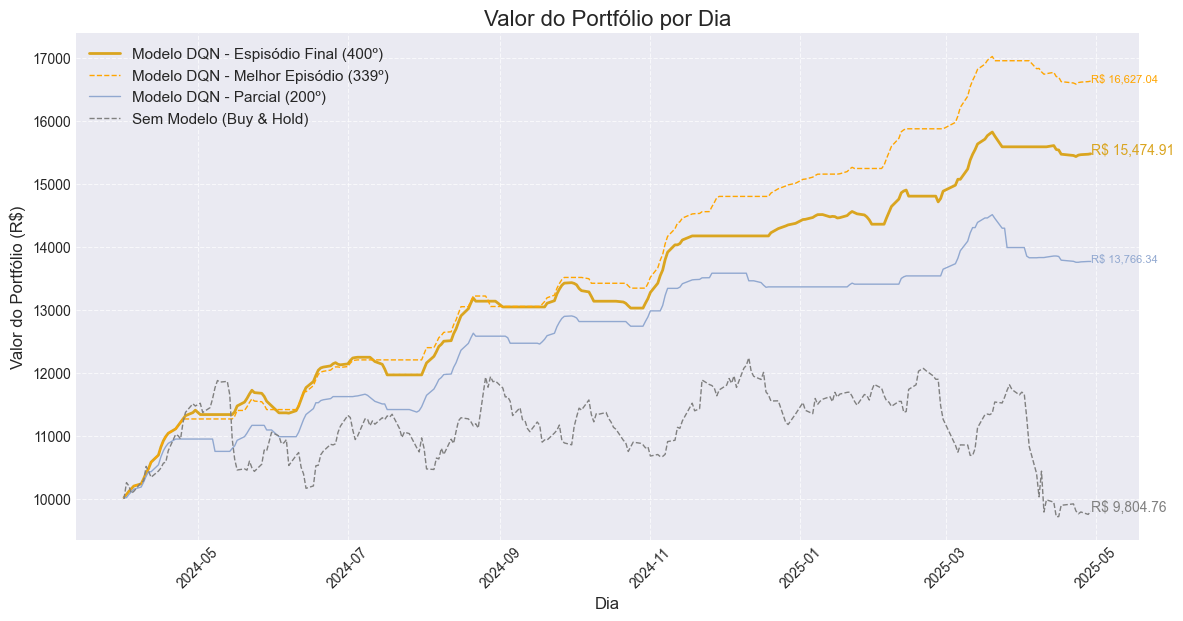

In [98]:
import pandas as pd 

initial_balance = 10000
num_acoes = initial_balance / df_petro['Close'].iloc[0]
portfolio_values_real = df_petro['Close'] * num_acoes

# Garantir que a coluna 'Date' está no formato datetime
df_petro['Date'] = pd.to_datetime(df_petro['Date'])

# Garantir que ambas as listas tenham o mesmo tamanho
min_length = min(len(last_daily_values), len(portfolio_values_real), len(df_petro['Date']))
last_daily_values = last_daily_values[:min_length]
portfolio_values_real = portfolio_values_real[:min_length]
dates = df_petro['Date'][:min_length]

# Estilo do gráfico
plt.style.use('seaborn-v0_8-darkgrid')  

# Plotando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(dates, last_daily_values, label=f'Modelo DQN - Espisódio Final ({last_episodio}º)', color='#DAA520', linewidth=2, linestyle='-')
plt.plot(dates, max_daily_values, label= f'Modelo DQN - Melhor Episódio ({max_episodio}º)', color='orange', linewidth=1, linestyle='--')
plt.plot(dates, mid_daily_values, label=f'Modelo DQN - Parcial ({mid_episodio}º)', color='#91A8D0', linewidth=1, linestyle='-')
plt.plot(dates, portfolio_values_real, label='Sem Modelo (Buy & Hold)', color='gray', linewidth=1, linestyle='--')

# Adicionando título e labels
plt.title("Valor do Portfólio por Dia", fontsize=16)
plt.xlabel("Dia", fontsize=12)
plt.ylabel("Valor do Portfólio (R$)", fontsize=12)

# Adicionando legendas e textos nos pontos finais
plt.legend(loc='best', fontsize=11)
plt.text(dates.iloc[-1], last_daily_values[-1], f'R$ {last_daily_values[-1]:,.2f}', color='#DAA520', fontsize=10)
plt.text(dates.iloc[-1], max_daily_values[-1],  f'R$ {max_daily_values[-1]:,.2f}',  color='orange',  fontsize=8)
plt.text(dates.iloc[-1], mid_daily_values[-1],  f'R$ {mid_daily_values[-1]:,.2f}',  color='#91A8D0', fontsize=8)
plt.text(dates.iloc[-1], portfolio_values_real.iloc[-1], f'R$ {portfolio_values_real.iloc[-1]:,.2f}', color='gray', fontsize=10)

# Adicionando a grade
plt.grid(True, linestyle='--', alpha=0.7)

# Ajustando layout e exibindo o gráfico
plt.tight_layout()
plt.xticks(rotation=45)  # Opcional, para girar as datas e evitar sobreposição
plt.show()
#9862


## 5.3 BR Foods

Episode 10/400 completed with portfolio of 10843. Com sugestão de ação 0 e recompensa acumulada de 164.1.
Episode 20/400 completed with portfolio of 10057. Com sugestão de ação 1 e recompensa acumulada de 116.0.
Episode 30/400 completed with portfolio of 10951. Com sugestão de ação 0 e recompensa acumulada de 174.5.
Episode 40/400 completed with portfolio of 10746. Com sugestão de ação 0 e recompensa acumulada de 173.2.
Episode 50/400 completed with portfolio of 12794. Com sugestão de ação 0 e recompensa acumulada de 233.9.
Episode 60/400 completed with portfolio of 13315. Com sugestão de ação 0 e recompensa acumulada de 278.7.
Episode 70/400 completed with portfolio of 13170. Com sugestão de ação 1 e recompensa acumulada de 228.1.
Episode 80/400 completed with portfolio of 14461. Com sugestão de ação 0 e recompensa acumulada de 298.0.
Episode 90/400 completed with portfolio of 14143. Com sugestão de ação 1 e recompensa acumulada de 317.3.
Episode 100/400 completed with portfolio of 16

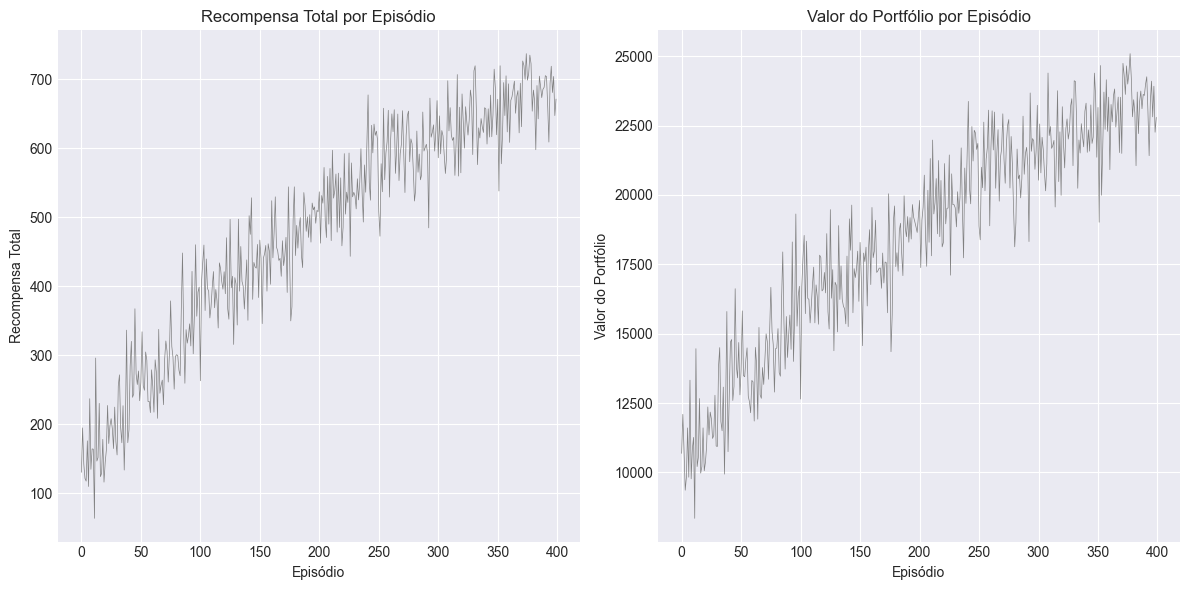

In [102]:
import matplotlib.pyplot as plt

# Definir o tamanho do estado e da ação
state_size = 9  # Preço, saldo, ações
action_size = 3  # Comprar, vender, manter

# Criar o ambiente de negociação
env = TradingEnvironment(df_brfoods['preco_suavizado'], initial_balance=10000)

# Criar o agente
state = env.reset()
agent = DQNAgent(state_size, action_size)

# Listas para armazenar métricas
total_rewards = []  # Para armazenar recompensa total por episódio
portfolio_values = []  # Para armazenar o valor do portfólio no final de cada episódio

# Treinamento
episodes = 400
max_portfolio_value = 0
last_episodio = []
mid_episodio = []
max_episodio = []

for episode in range(episodes):
    state = env.reset()
    done = False
    episode_reward = 0  # Recompensa acumulada por episódio
    daily_values = []
    step_count = 0
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.store_experience(state, action, reward, next_state, done)
        step_count += 1
        if step_count % 1 == 0:
            agent.train()
        state = next_state
        episode_reward += reward  # Acumulando a recompensa no episódio
        
        daily_values.append(env.portfolio_value)
    
    # Atualizar a exploração
    agent.update_epsilon()
    
    # Armazenar métricas
    total_rewards.append(episode_reward)
    portfolio_values.append(env.portfolio_value)
    
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}/{episodes} completed with portfolio of {round(env.portfolio_value)}. Com sugestão de ação {action} e recompensa acumulada de {round(episode_reward,1)}.")
    
    # Armazenar o valor do portfólio diário para análise gráfica
    if episode == episodes - 1:
        last_daily_values = daily_values
        last_episodio = episode + 1
    
    if episode == (episodes)/2:
        mid_daily_values = daily_values
        mid_episodio = episode
    
    if daily_values[-1] >= max_portfolio_value:
        max_portfolio_value = daily_values[-1]
        max_episodio = episode + 1
        max_daily_values = daily_values

# Plotar as métricas
plt.figure(figsize=(12, 6))

# Gráfico de recompensa total por episódio
plt.subplot(1, 2, 1)
plt.plot(total_rewards, color='gray', linewidth=0.5)
plt.title("Recompensa Total por Episódio")
plt.xlabel("Episódio")
plt.ylabel("Recompensa Total")

# Gráfico do valor do portfólio ao longo dos episódios
plt.subplot(1, 2, 2)
plt.plot(portfolio_values, color='gray', linewidth=0.5)
plt.title("Valor do Portfólio por Episódio")
plt.xlabel("Episódio")
plt.ylabel("Valor do Portfólio")

plt.tight_layout()
plt.show()


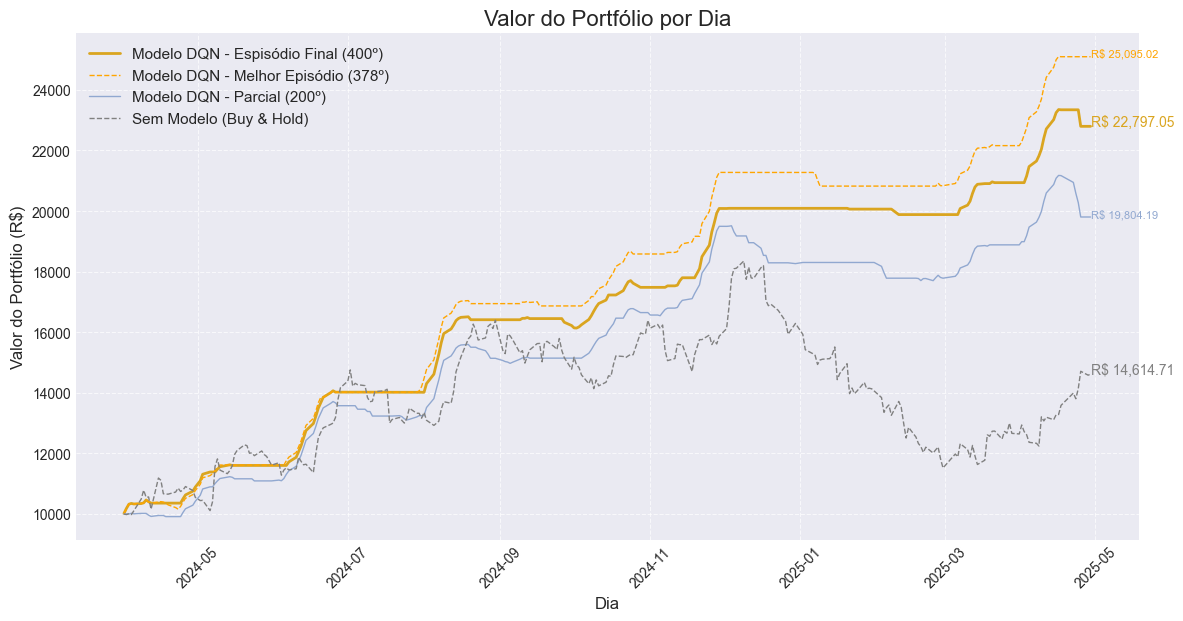

In [103]:
import pandas as pd 

initial_balance = 10000
num_acoes = initial_balance / df_brfoods['Close'].iloc[0]
portfolio_values_real = df_brfoods['Close'] * num_acoes

# Garantir que a coluna 'Date' está no formato datetime
df_brfoods['Date'] = pd.to_datetime(df_brfoods['Date'])

# Garantir que ambas as listas tenham o mesmo tamanho
min_length = min(len(last_daily_values), len(portfolio_values_real), len(df_brfoods['Date']))
last_daily_values = last_daily_values[:min_length]
portfolio_values_real = portfolio_values_real[:min_length]
dates = df_brfoods['Date'][:min_length]

# Estilo do gráfico
plt.style.use('seaborn-v0_8-darkgrid')  

# Plotando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(dates, last_daily_values, label=f'Modelo DQN - Espisódio Final ({last_episodio}º)', color='#DAA520', linewidth=2, linestyle='-')
plt.plot(dates, max_daily_values, label= f'Modelo DQN - Melhor Episódio ({max_episodio}º)', color='orange', linewidth=1, linestyle='--')
plt.plot(dates, mid_daily_values, label=f'Modelo DQN - Parcial ({mid_episodio}º)', color='#91A8D0', linewidth=1, linestyle='-')
plt.plot(dates, portfolio_values_real, label='Sem Modelo (Buy & Hold)', color='gray', linewidth=1, linestyle='--')

# Adicionando título e labels
plt.title("Valor do Portfólio por Dia", fontsize=16)
plt.xlabel("Dia", fontsize=12)
plt.ylabel("Valor do Portfólio (R$)", fontsize=12)

# Adicionando legendas e textos nos pontos finais
plt.legend(loc='best', fontsize=11)
plt.text(dates.iloc[-1], last_daily_values[-1], f'R$ {last_daily_values[-1]:,.2f}', color='#DAA520', fontsize=10)
plt.text(dates.iloc[-1], max_daily_values[-1],  f'R$ {max_daily_values[-1]:,.2f}',  color='orange',  fontsize=8)
plt.text(dates.iloc[-1], mid_daily_values[-1],  f'R$ {mid_daily_values[-1]:,.2f}',  color='#91A8D0', fontsize=8)
plt.text(dates.iloc[-1], portfolio_values_real.iloc[-1], f'R$ {portfolio_values_real.iloc[-1]:,.2f}', color='gray', fontsize=10)

# Adicionando a grade
plt.grid(True, linestyle='--', alpha=0.7)

# Ajustando layout e exibindo o gráfico
plt.tight_layout()
plt.xticks(rotation=45)  # Opcional, para girar as datas e evitar sobreposição
plt.show()
#9862
